In [6]:
import numpy as np
import scipy as sp
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
import numpy.linalg as LA

# SINDy and PDEs

Here we discuss using SINDy to find solutions to nonlinear PDEs by first simulating data using a split-step method and finally running the sparse regression on the spaical and temporal derivatives to extract the nonlinear terms. 

## Split-Step Method

We start by simulating our desired PDE using a split-step method. For the purposes of this demonstration we will be using Burger's Equation 
$$
u_t = u_x-uu_x+0.0001u_{xx}
$$
here we include defusion for numerical stability in the simulation.

We collect the data in an $m\times n$ matrix where $m$ is the number of timesteps and n is our spacial resolution.

 99%|████████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:00<00:00, 73.70it/s]


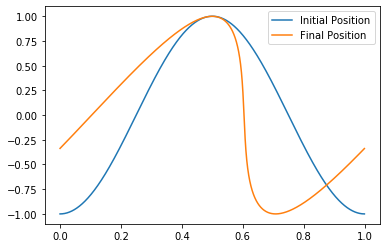

In [2]:
global L, NL, U, Ul, Unl, x, xt, xtft, k
global mu, alpha, beta, dt, NPoint, Lx

### Parameters/Inputs

NPoints = 2**11      # Spacial Resolution
t_stop = .15        # Stoping Time
dt = .0001           # Time step size
sampling_rate = 20   # How often do you save?
Lx = 1               # Space Size

# Input Coefficients [1, u, u_x, u_xx, u^2, u*u_x, u*u_xx, u_x^2, u_x*u_xx, u_xx^2]
c = [0,0,1,.0001,0,-1, 0 ,0,0,0] #Burger's Equation


### Matrices 
dx = Lx/NPoints                             # Space step size 
t = np.arange(0, NPoints)                   # time space      
kx = np.fft.fftfreq(NPoints, 1/NPoints)     # Frequency for fourier transform
kx = 2*np.pi/Lx*kx                          # Adjusting by length of interval
L = c[1] + c[2]*1j*kx - c[3]*kx**2          # Calculate Linear piece exactly        
NL = np.empty(NPoints, dtype = complex)     # Allocate Space for Nonlinear

for j in range(NPoints):                    # Calculate Nonlinear piece
    if abs(L[j])<0.000001:
        NL[j] = dt 
    else:
        NL[j] = (np.exp(L[j]*dt)-1)/L[j]


### Initial Condition

x = t/NPoints*Lx
U = np.cos(2*np.pi*(x-Lx/2)/Lx) # Initial Condition here


# Plot initial condition

fig1 = plt.figure()
ax1 = plt.axes()
ax1.plot(x, U, label = 'Initial Position')
Ul = np.fft.fft(U)


# Calculate Derivatives for first step

U_x = np.fft.ifft(1j*kx*np.fft.fft(U))
U_xx = np.fft.ifft(-kx**2*np.fft.fft(U))


# Find Nonlinear piece

Unl = np.fft.fft(np.dot(c[4:], [U**2, U*U_x, U*U_xx, U_x**2, U_x*U_xx, U_xx**2]))

imax = int(t_stop/(dt*sampling_rate)) 
kmax = sampling_rate

U_save = np.empty([NPoints,imax-1], dtype = complex)
U_save[:,0] = U


### Time Evolution

pbar = tqdm(total = imax-1,position = 0, leave = True)

for i in range(1,imax-1):
    
    for k in range(kmax):
        U = np.multiply(np.exp(L*dt),Ul)+np.multiply(NL, Unl) # Move Forward in Fourier Space
        Ul = np.fft.ifft(U) # Move back to real space
        if k == kmax-1:
            U_save[:,i] = Ul # Save every sampling_rate timesteps
        U_x = np.fft.ifft(1j*kx*U) # Calculate new derivatives
        U_xx = np.fft.ifft(-kx**2*U)
        Unl = np.fft.fft(np.dot(c[4:], [Ul**2, Ul*U_x, Ul*U_xx, U_x**2, U_x*U_xx, U_xx**2])) # Calculate new nonlinear piece
        Ul = U
        if np.isnan(Ul[0]) == True:
            sys.exit()
    pbar.update(1)        
pbar.close()     
       
psi2 = np.fft.ifft(Ul)
ax1.plot(x, np.real(psi2), label = 'Final Position')       
ax1.legend()
plt.show()

We can then animate our final solution.

In [3]:
import matplotlib.animation as animation
%matplotlib qt
j=0
fig = plt.figure()
fig.set_dpi(100)
ax2= plt.axes() 

def animate(j):
    j +=1 
    ax2.clear()
    ax2.plot(x,np.real(U_save[:,j]))
    ax2.plot(0,0, label = j/imax)
    ax2.legend()
    ax2.set_ylim(-2,2)
    ax2.set_xlim(0,Lx)
    
    
anim = animation.FuncAnimation(fig,animate, frames=100, interval = 100, repeat = True)

## Using SINDy

We now feed these time series into SINDy. We first calculate spacial derivatives in Fourier space to attain spectral accuracy, as oppsoed to finite differences. It should be noted that this bears the assumption that our space behaves periodically. If this is not the case, higher-order finite difference methods can be employed to attain similar results. When approximating the time derivative, we use a central difference, with a one-sided 2nd order finite difference method on the boundaries. However, we have updated this to work with higher-order differentiations to create the uploaded plots below. It should be noted that we have found no noticable difference between the two differentiation methods. These create $m\times n $ matricies of $u_t,u_x,$ and $u_{xx}$.

In [13]:
U = np.real(np.transpose(U_save))
pbar_t = tqdm(total = U.shape[0]-1, position = 0, leave = True)
### Estimate Time Derivatives
U_t = np.empty(U.shape, dtype = complex)
for i in range(U.shape[0]-1):
        U_t[i,:] = (U[i+1,:]-U[i-1,:])/(2*dt)
        pbar_t.update(1)

pbar_t.close()

        
U_t[0,:] = (-3/2*U[0,:]+2*U[1,:]-1/2*U[2,:])/dt
U_t[-1,:] = (1/2*U[-3,:]-2*U[-2,:]+3/2*U[-1,:])/dt

U_x = np.fft.ifft(1j*kx*np.fft.fft(U, axis = 1))
U_xx = np.fft.ifft(-kx**2*np.fft.fft(U, axis = 1))


100%|███████████████████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 14580.89it/s]


In order to use SINDy for linear regression, we must first transform our matrices into vectors. For $u, u_t, u_x, u_{xx}$ we transform each $m\times n$ matrix into a $mn\times 1$ vector and proceed by using SINDy as normal. Our library of $u, u_x, u_{xx}$ is used to construct $\Theta$ which consists of the functions $1, u, u_x, u_{xx}, u^2, uu_x, uu_{xx}, u_x^2, u_xu_{xx}, u_{xx}^2$. However it can be easily modified to include other terms such as $|u|$, higher order terms or other nonlinearities. 


In [14]:
U_new = U.flatten(order = 'F')
U_t_new = U_t.flatten(order = 'F')
U_x_new = U_x.flatten(order = 'F')
U_xx_new = U_xx.flatten(order = 'F')

Library = np.column_stack([U_new,U_x_new,U_xx_new])

total_variable = 3
total_guesses = 1+total_variable+6
Theta = np.empty([(U.shape[0])*U.shape[1], total_guesses], dtype = complex)

i = 0
Theta[:,i] = np.ones([(U.shape[0])*U.shape[1]])
i = i+1

for j in range(total_variable):
    Theta[:,i] = Library[:, j]
    i = i+1

# Uncomment if quadratic terms are desired 
for j in range(total_variable):
    for l in range(total_variable-j):
        Theta[:,i] = Library[:,j]*Library[:,l+j]
        i = i+1

We then process this through SINDy using a thresholding regression to solve 
$$
u_t = \Theta(u, u_x, u_{xx})\Xi
$$

Here we implement a threshold of 1, but this should be modified for specific equations and expected coefficients.

In [17]:
Xi_sindy = LA.lstsq(Theta,U_t_new, rcond = None)[0]

l=.1

for k in range(10):
    condition = np.abs(Xi_sindy) > l
    Xi_sindy = np.where(condition, Xi_sindy, np.zeros(Xi_sindy.shape))
    
    for j in range(1):
        vec = condition[:,]
        bigind = [i for i in range(len(vec)) if vec[i] == True]
        Xi_sindy[bigind] = LA.lstsq(Theta[:, bigind], U_t_new, rcond = None)[0]
Print = ['1','u','u_x','u_xx','u^2', 'uu_x','uu_xx', 'u_x^2', 'u_xu_xx','u_xx^2']
Print_1 = []
for i in range(total_guesses):
    Print_1.append([Print[i], Xi_sindy[i]])
    print(Print_1[i])

['1', 0j]
['u', (-0.11164670170946188+0j)]
['u_x', (19.989910527363214-3.198396408832238e-18j)]
['u_xx', 0j]
['u^2', 0j]
['uu_x', (-19.911051315410194-3.642919299551295e-16j)]
['uu_xx', 0j]
['u_x^2', 0j]
['u_xu_xx', 0j]
['u_xx^2', 0j]


When we consider our sampling rate, we would expect our results $\Xi_{\text{found}} = \text{sampling rate}\cdot \Xi_{\text{actual}}$. This is because $dt$ is scaled by a factor of the sampling rate when compared to the simulation. So when we correct for this, we would expect to get the original results.

In [18]:
Print_1 = []
for i in range(total_guesses):
    Print_1.append([Print[i], Xi_sindy[i]/sampling_rate])
    print(Print_1[i])

['1', 0j]
['u', (-0.005582335085473095+0j)]
['u_x', (0.9994955263681607-1.5991982044161191e-19j)]
['u_xx', 0j]
['u^2', 0j]
['uu_x', (-0.9955525657705098-1.8214596497756474e-17j)]
['uu_xx', 0j]
['u_x^2', 0j]
['u_xu_xx', 0j]
['u_xx^2', 0j]


## Error Analysis

Below we will explore a few different methods of analyzing the error. First we will consider reasonable simulation resolution and adjust our sampling of this data. This would indicate how frequent sampling of an experiment would need to be in order to achieve reasonable accuracy of the PDE. 

The second error analysis we will consider is that of the actual simulation's resolution. That is, as our simulation becomes more accurate (with a fixed sampling rate), how does this impact the error of our discovered model. One would expect that the finer the simulation's resolution, the more accurate our regression will be. 

### Sampling Rate

From here, we can consider some error analysis based on the sampling rate of the data. So, assuming we have a good simulation, how frequently do we need to sample the data to find a somewhat recognizable PDE. For this, we consider sampling rates of every point, up to every 1000th point in the simulation. The for-loop can be constructed using the code above. The resulting image can be seen below.

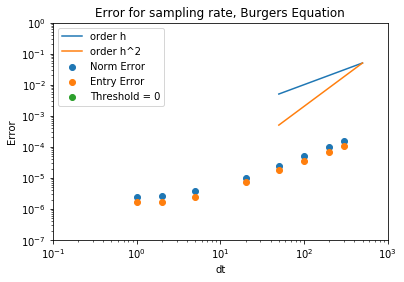

In [8]:
from IPython.display import Image
Image(filename=r"C:\Users\frieswd\Desktop\Python\SINDy Testing\PDE\Split-Step\Burger_Error_lele_no_threshold.png")

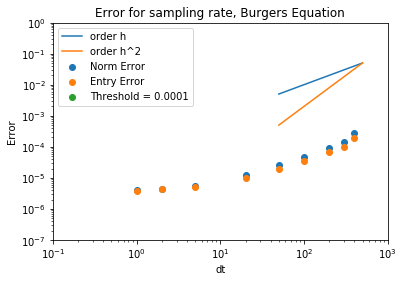

In [9]:
Image(filename=r"C:\Users\frieswd\Desktop\Python\SINDy Testing\PDE\Split-Step\Burger_Error_lele_with_threshold.png")

Comparing both of these images, we can see that the thresholding does not drasitcally impact the convergence of the final solution. We might expect the other sparse regression tools to achieve better results. However, visually, it should be noted that using the thresholding makes it significanly easier when reconstructing the PDE using simulations. 

### Simulation Resolution (dt)

We now consider the simulations resolution for the Burgers Equation. To do this, we consider varying time steps in our initial simulation. We start with $.1$ and continue to $.0001$ before computer memory restricts further analysis. All other parameters have stayed the same and we sample every $100^{th}$ point. To accomodate the larger dt values (and to prevent overflow errors), we rescale our system as follows: 

In [13]:
for step in [1,2,3,4]:
    ### Burgers
    NPoints = 2**11      # Spacial Resolution
    t_stop = 150        # Stoping Time
    dt = 10**(-step)           # Time step size
    sampling_rate = 100   # How often do you save?
    Lx = 1               # Space Size

    # Input Coefficients [1, u, u_x, u_xx, u^2, u*u_x, u*u_xx, u_x^2, u_x*u_xx, u_xx^2]
    c = [0,0,.001,.0000001,0,-.001, 0 ,0,0,0]

We run these simulations along with model-discovery resgression with and without thresholding. The graphs are displayed below. It should be noted that when considering thresholding, we must accomdate the smallest coeffifcient or expect our error to level-off at $10^{-8}$. Because we have not seen this level of accuracy from general simulations, we use a larger threshold in the regression. 

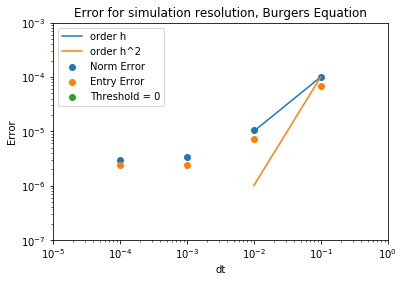

In [14]:
Image(filename=r"C:\Users\frieswd\Desktop\Python\SINDy Testing\PDE\Split-Step\Burgers_Error_dt.png")

## Exploring Different Equations

We have also taken these results and explored other nonlinear pdes. These include the reaction diffusion equation ($u_t = \alpha u_xx + \beta u(1-u)$) and nonlinear shrodingers (CGL) ($u_t = \mu u + (1+\alpha i) u_{xx} + (1+\beta i)|u|^2u$). We will first discuss the results for the reaction diffusion equation.

### Reaction Diffusion

We start with a very generic setup for this equation, with reasonable coefficients and an initial condition of $$u(0,x) = \cos\left(\frac{2\pi x}{L}\right)+\cos\left(\frac{10\pi x}{L}\right).$$

In [25]:
### Reaction Diffusion
NPoints = 2**11      # Spacial Resolution
t_stop = .4        # Stoping Time
dt = .0001           # Time step size
sampling_rate = 10  # How often do you save?
Lx = 1               # Space Size

# Input Coefficients [1, u, u_x, u_xx, u^2, u*u_x, u*u_xx, u_x^2, u_x*u_xx, u_xx^2]
c = [0,-2,0,.001,2,0,0,0,0,0]

We then run the split-step simulation and input the data into SINDy to see if we can discover the same equation. As expected, the results are similar to those from Burger's Equation. 

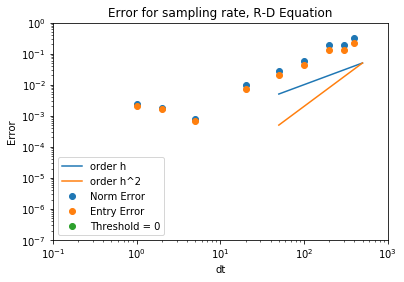

In [10]:
Image(filename=r"C:\Users\frieswd\Desktop\Python\SINDy Testing\PDE\Split-Step\R_D_Error_no_threshold.png")

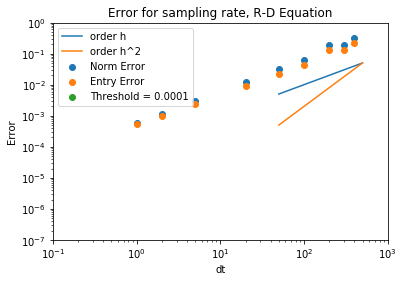

In [11]:
Image(filename=r"C:\Users\frieswd\Desktop\Python\SINDy Testing\PDE\Split-Step\R_D_Error_with_threshold.png")

Here, we can see that when using a threshold, the noise causes our error to level off around $10^{-3}$. However, when using the thresholding, we achieve more consistent error results with a convergence rate of $h^2$. This result has not been proven theoretically; however we can visually see this behavior. 

As above, we can also consider the simluation resolution for the Reaction Diffusion equation. These results... (code is running)

### CGL (to come)